# Assignment 4


## Theory

### a) Optimal Portfolios 

The investors maximization problem is equivalent to

$\max_{w^i}\left(R_f+{w^i}'(\mu- R_f\mathbf{1})-\frac{\gamma_i}{2} {w^i}' \Sigma w^i \right)$




The first order condition is 

$\mu- R_f\mathbf{1} = \gamma^i \Sigma w^i$



which implies that

${w^i}^* = \frac{1}{\gamma^i}\Sigma^{-1}(\mu- R_f\mathbf{1})$




Defining

$w_{tan}:= \frac{\Sigma^{-1}(\mu- R_f\mathbf{1})}{\mathbf{1}'\Sigma^{-1}(\mu- R_f\mathbf{1})}$



one can rewrite the investors optimal portfolio as

$ {w^i}^*= \frac{\mathbf{1}'\Sigma^{-1}(\mu- R_f\mathbf{1})}{\gamma^i} w_{tan}$

${w^i_0}^*= 1-\frac{\mathbf{1}'\Sigma^{-1}(\mu- R_0\mathbf{1})}{\gamma^i}$

Because $\mathbf{1}'{w^i}^* + {w^i_0}^* = 1$ we can decompose the investors wealth as 

$W^i = W_0^i + W_{MV}^i$

where $W_0^i = W^i{w^i_0}^*$ and $W_{MV}^i = W^i\mathbf{1}'{w^i}^*$

### b) Equilibrium

Equilibrium market clearing for the risk free asset, which is in 0 net supply

$\sum_i W_0^i = 0$


Equilibrium market clearing for any risky asset, which is supply $M_n$


$\sum_i W_{MV}^i w_{tan,n} = M_n \quad \forall n = 1, ...,N$

$w_{tan,n} \sum_i W_{MV}^i = M_n \quad \forall n = 1, ...,N$

Summing across all $N$ risky assets yields $\sum_i W_{MV}^i = \sum_n M_n $. Plugging in and rearranging we get


$w_{tan,n} \sum_n M_n = M_n \quad \forall n = 1, ...,N$

$w_{tan,n}  = \frac{M_n}{\sum_n M_n} = w_{M,n} \quad \forall n = 1, ...,N$




...and in vector notation:

$w_{tan} = w_{M}$

### c) Market Risk Premium

The first order condition from above was

${w^i}^* = \frac{1}{\gamma^i}\Sigma^{-1}(\mu- R_f\mathbf{1})$

Coomputing a wealth-weighted sum across all investors with weights $\frac{W^i}{\sum_i W^i}$ yields

$\underbrace{\sum_i \frac{W^i}{\sum_i W^i} {w^i}^*}_{w_M} = \frac{1}{\gamma_M}\Sigma^{-1}(\mu- R_f\mathbf{1})$


Rearranging yields

$\mu - R_f\mathbf{1} = \gamma_M \Sigma w_M$

Multiplying by market weights $w_M'$ yields

$\mu_M - R_f = \gamma_M w_M'\Sigma w_M$

$\mu_M - R_f = \gamma_M \sigma^2_M$

$\gamma_M = \frac{\mu_M - R_f}{\sigma^2_M} = \frac{\text{Market Sharpe Ratio}}{\sigma_M}$ is the wealth-weighted average risk aversion in the economy. The more risk aversion there is, the higher the compensation required to hold risky assets. Therefore, if investors are more risk averse, the risky market portfolio must offer a higher sharpe ratio in equilibrium.

### d) Security Market Line

From above, we have that 

$\mu - R_f\mathbf{1} = \gamma_M \Sigma w_M$

I.e. expected excess returns are proportional to risk aversion and covariance with the market portfolio.
Plugging in the expression for $\gamma_M$ from above yields

$\mu = R_f\mathbf{1} + \underbrace{\frac{\Sigma w_M}{\sigma^2_M}}_{\beta}(\mu_M - R_f)$

Writing in asset-specific notation

$\mu_n = R_f + \beta_n(\mu_M - R_f)$

## Empirics

### Set up connection to WRDS...

In [27]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
db=wrds.Connection(wrds_username='perusset')
#db.create_pgpass_file()


Enter your WRDS username [perusset]:perusset
Enter your password:········


OperationalError: (psycopg2.OperationalError) connection to server at "wrds-pgdata.wharton.upenn.edu" (165.123.60.118), port 9737 failed: SSL connection has been closed unexpectedly

(Background on this error at: https://sqlalche.me/e/20/e3q8)

### Download and format data

In [37]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1928-01-01'
            and mcaldt<='2004-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1928-01-01' and date<='2004-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1928' and '12/31/2004'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data.to_csv('data.csv', sep=';',index=False) # export data


In [44]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [50]:
# Import data
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])  # First, ensure that "date" is in datetime format
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10092,2000-09-29,-0.196429,11865.0,16.8750,2.002219e+05,NaN,0.004933,-0.051154,1,-0.201362,-0.056087
1,10092,2000-10-31,-0.144444,11865.0,14.4375,1.713009e+05,2.002219e+05,0.005023,-0.024480,1,-0.149467,-0.029503
2,10092,2000-11-30,-0.251082,12080.0,10.8125,1.306150e+05,1.713009e+05,0.005099,-0.102365,1,-0.256181,-0.107464
3,10092,2000-12-29,-0.173410,12080.0,8.9375,1.079650e+05,1.306150e+05,0.004808,0.020450,1,-0.178218,0.015642
4,10092,2001-01-31,0.588811,12080.0,14.2000,1.715360e+05,1.079650e+05,0.004023,0.039573,1,0.584788,0.035550
...,...,...,...,...,...,...,...,...,...,...,...,...
1470782,92567,1989-06-30,0.082279,110738.0,21.3750,2.367025e+06,2.186838e+06,0.006879,-0.004856,1,0.075400,-0.011735
1470783,92567,1989-07-31,0.040936,110738.0,22.2500,2.463920e+06,2.367025e+06,0.006536,0.077128,1,0.034400,0.070592
1470784,92567,1989-08-31,-0.106742,110738.0,19.8750,2.200918e+06,2.463920e+06,0.006488,0.022126,1,-0.113230,0.015638
1470785,92567,1989-09-29,0.339623,110738.0,26.6250,2.948399e+06,2.200918e+06,0.006461,-0.001473,1,0.333162,-0.007934


In [51]:
data['w_m'] = data['mcap_l']/data.groupby(['date'])['mcap_l'].transform('sum')

## Compute Stock-Specific Betas

C:\Users\perusset\AppData\Local\Temp\ipykernel_28056\2730350630.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Parameters = data.groupby('permno').apply(lambda x: sm.OLS(x['Rn_e'],x[['const','Rm_e']]).fit().params).reset_index()
C:\Users\perusset\AppData\Local\Temp\ipykernel_28056\2730350630.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Systematic_Var = data.groupby('permno').apply(lambda x: sm

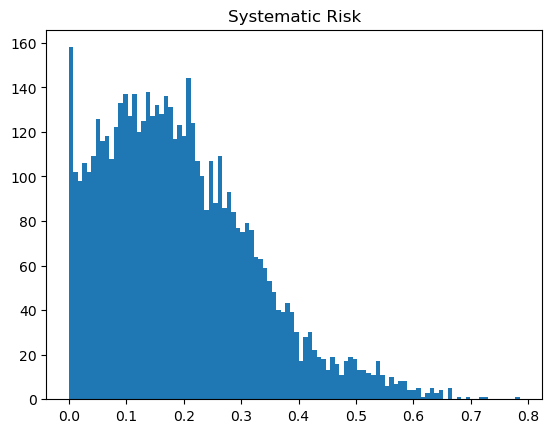

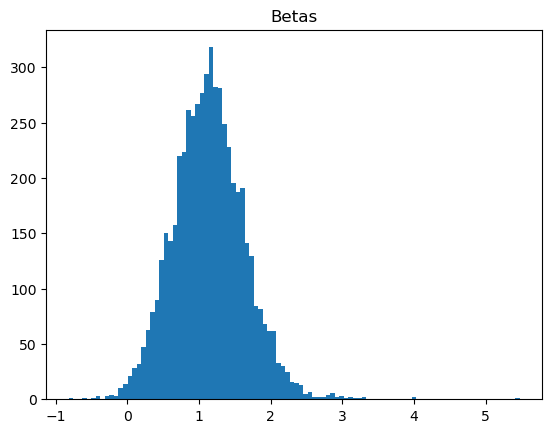

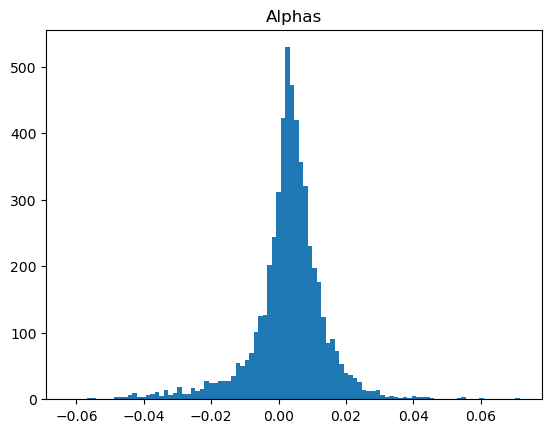

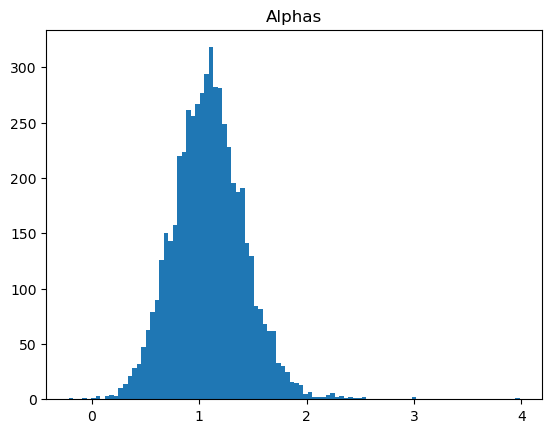

((array([  1.,   0.,   0.,   1.,   0.,   1.,   3.,   0.,   3.,   4.,   3.,
          10.,  14.,  21.,  28.,  32.,  47.,  63.,  79.,  90., 126., 150.,
         143., 157., 220., 223., 261., 256., 267., 277., 294., 318., 282.,
         281., 249., 228., 195., 187., 191., 141., 129.,  84.,  82.,  68.,
          62.,  62.,  33.,  30.,  25.,  16.,  15.,  13.,   5.,   7.,   2.,
           2.,   2.,   4.,   6.,   2.,   3.,   1.,   2.,   1.,   1.,   2.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           1.]),
  array([-2.11412184e-01, -1.69448976e-01, -1.27485767e-01, -8.55225589e-02,
         -4.35593504e-02, -1.59614190e-03,  4.03670666e-02,  8.23302751e-02,
          1.24293484e-01,  1.66256692e-01,  2.08219901e-01,  2.50183109e-01,
          2.92146318e-01,  3.34109526e-01,  3.76072735e-01,  4.18035943e-01,


In [47]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 1. Remove stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()

# 2. Estimate Betas
import statsmodels.api as sm
Parameters = data.groupby('permno').apply(lambda x: sm.OLS(x['Rn_e'],x[['const','Rm_e']]).fit().params).reset_index()
Parameters = Parameters.rename(columns={'Rm_e':'beta','const':'alpha'})
Systematic_Var = data.groupby('permno').apply(lambda x: sm.OLS(x['Rn_e'],x[['const','Rm_e']]).fit().rsquared)

# 3. Shrinkage Estimator
Parameters['beta_shrinkage'] = (2/3)*Parameters['beta'] + (1/3)
plt.hist(Systematic_Var,bins=100),plt.title('Systematic Risk') , plt.show()
plt.hist(Parameters.beta,bins=100),plt.title('Betas') , plt.show()
plt.hist(Parameters.alpha,bins=100),plt.title('Alphas') , plt.show()
plt.hist(Parameters.beta_shrinkage,bins=100),plt.title('Alphas') , plt.show()

## Sort Betas into Portfolios

In [48]:
# 1. Merge Lagged Market Cap and Return
Portfolios = pd.merge(data[['date','permno','mcap_l','Rn']],Parameters,on=['permno'], how='left')

# 2. Groups
Portfolios['Decile'] = Portfolios.groupby('date')['beta'].transform(lambda x: pd.qcut(x,10,labels=False))

# 3. Market Weights
Portfolios['wm'] = Portfolios['mcap_l']/Portfolios.groupby(['date','Decile'])['mcap_l'].transform('sum')
Portfolios['Beta_Return_vw'] = Portfolios['Rn']*Portfolios['wm']
Portfolios['Beta_Return_ew'] = Portfolios['Rn']/Portfolios.groupby(['date','Decile'])['permno'].transform('count')

# 4. Value-Weighted and Equal-Weighted Return
Portfolio_Return = Portfolios.groupby(['date','Decile'])[['Beta_Return_vw','Beta_Return_ew']].sum().reset_index()

# 5. Merge Market Return
Rm = data[['date','Rm']].drop_duplicates()
Rf = data[['date','rf']].drop_duplicates()
Portfolio_Return = pd.merge(Portfolio_Return, Rm,on=['date'], how='left')
Portfolio_Return = pd.merge(Portfolio_Return, Rf,on=['date'], how='left').dropna()
Portfolio_Return['Beta_Excess_Return_ew'] = Portfolio_Return['Beta_Return_ew']-Portfolio_Return['rf']
Portfolio_Return['Beta_Excess_Return_vw'] = Portfolio_Return['Beta_Return_vw']-Portfolio_Return['rf']
Portfolio_Return['Rm_e'] = Portfolio_Return['Rm']-Portfolio_Return['rf']

# 6. Compute Beta of Each Portfolio
Portfolio_Return['const'] = 1
Portfolio_Beta_ew = Portfolio_Return.groupby('Decile').apply(lambda x: sm.OLS(x['Beta_Excess_Return_ew'],x[['const','Rm_e']]).fit().params[1])
Portfolio_Beta_vw = Portfolio_Return.groupby('Decile').apply(lambda x: sm.OLS(x['Beta_Excess_Return_vw'],x[['const','Rm_e']]).fit().params[1])

# 7. Compute Average Excess Return of Each Portfolio
Portfolio_Ret_ew = Portfolio_Return.groupby('Decile')['Beta_Excess_Return_ew'].mean()
Portfolio_Ret_vw = Portfolio_Return.groupby('Decile')['Beta_Excess_Return_vw'].mean()

# 8. Merge
tmp = pd.concat([Portfolio_Beta_ew,Portfolio_Beta_vw,Portfolio_Ret_ew,Portfolio_Ret_vw], axis=1)
tmp.columns = ['beta_ew','beta_vw','ret_ew','ret_vw']
tmp[['ret_ew','ret_vw']] = tmp[['ret_ew','ret_vw']]*12

C:\Users\perusset\AppData\Local\Temp\ipykernel_28056\3265337977.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Portfolio_Beta_ew = Portfolio_Return.groupby('Decile').apply(lambda x: sm.OLS(x['Beta_Excess_Return_ew'],x[['const','Rm_e']]).fit().params[1])
C:\Users\perusset\AppData\Local\Temp\ipykernel_28056\3265337977.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Portfolio_Beta_ew = Portfolio_Return.groupby('Decile').apply(lambda x: sm.OLS(x['Beta_Excess_Return_ew'],x[['const','Rm_e']]).fit().params[1])
C:\Users\perusset\AppData\Local\Temp\ipykernel_28056\3265337977.py:26: FutureWarning: Series.__getitem__

## Plot Security Market Line

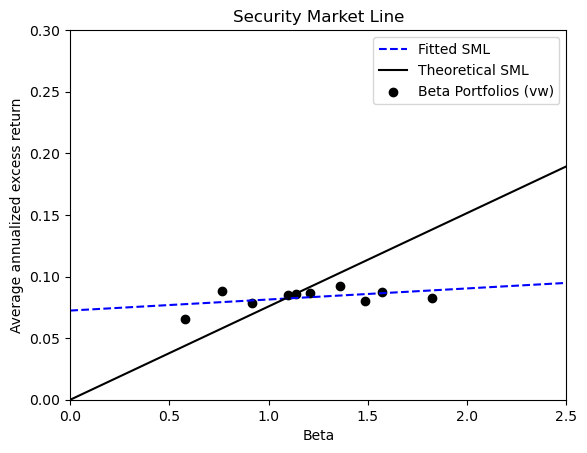

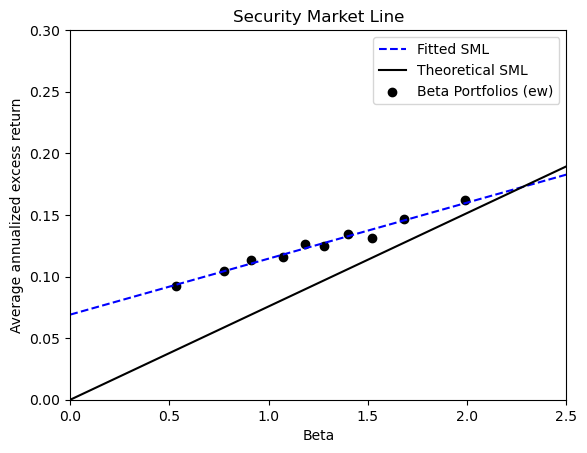

In [49]:
# Fit line through decile plots
for wt in ['vw','ew']:
    tmp['const'] = 1
    fit = sm.OLS(tmp['ret_'+wt], tmp[['const','beta_'+wt]]).fit()
    fl=fit.params.values[0]+fit.params.values[1]*np.arange(0,4)

    # Simulated line
    sl= (Rm['Rm'].mean()-Rf['rf'].mean())*np.arange(0,4)*12

    plt.plot(np.arange(0,4),fl,color='blue',linestyle='--')
    plt.plot(np.arange(0,4),sl,color='black')
    plt.scatter(tmp['beta_'+wt],tmp['ret_'+wt],color='black')
    plt.xlabel('Beta')
    plt.ylabel('Average annualized excess return')
    plt.xlim(0, 2.5)
    plt.ylim(0, 0.3)
    plt.title('Security Market Line')
    plt.legend(['Fitted SML','Theoretical SML','Beta Portfolios ('+wt+ ')'], loc=0)
    plt.savefig('SML_Test_' +wt + '.pdf')
    plt.show()